# 1、数据说明
## (1) X：本研究使用15个技术指标，其中每个技术指标有15个不同的周期长度，因此得到的特征（因子数）为225（15×15）个。然后将225个特征转换为15×15的图像。 即：将数据从 samples×225 变成 samples×15×15再变成samples ×3 × 15 × 15 (简单复制)，其中samples为样本量，3为通道数，15×15分别为图片的长和宽。
## (2) Y：将数据标记为0：买入(buy)、1：卖出(sell) 和 2：持有(hold)  (具体标记方法见create_labels函数)

# 2、模型选择
## 使用CNN网络进行训练以及预测

# 3、数据预处理

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *
from ta import *
from stockstats import StockDataFrame as sdf
import time


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# 基础数据
data = pd.read_csv("C:/Users/82706/Desktop/CNN-图像/stock_history/WMT/WMT.csv",index_col=0)
data.sort_index(ascending=True, inplace=True)
data.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2000-01-10,67.25,67.50,65.63,67.25,46.7049,6714300,0.0,1.0
2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,0.0,1.0
2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,0.0,1.0
2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,0.0,1.0
2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,0.0,1.0


## 3.1 生成X
### X包含：RSI、williamR、mif、ROC、CMF、CMO、SMA、EMA、WMA、HMA、TRIX、CCI、DPO、kst、DMI、BB_MAV、force_index、kdjk_rsv、EOM

In [3]:
##################计算特征（因子）函数#####################
def get_RSI_smooth(df, col_name, intervals):
    """
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    """
    print("Calculating RSI")
    prev_rsi = np.inf
    prev_avg_gain = np.inf
    prev_avg_loss = np.inf
    rolling_count = 0

    def calculate_RSI(series, period):
        # nonlocal rolling_count
        nonlocal prev_avg_gain
        nonlocal prev_avg_loss
        nonlocal rolling_count

        curr_gains = series.where(series >= 0, 0)  # replace 0 where series not > 0
        curr_losses = np.abs(series.where(series < 0, 0))
        avg_gain = curr_gains.sum() / period  # * 100
        avg_loss = curr_losses.sum() / period  # * 100
        rsi = -1

        if rolling_count == 0:
            # first RSI calculation
            rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
            # print(rolling_count,"rs1=",rs, rsi)
        else:
            # smoothed RSI
            # current gain and loss should be used, not avg_gain & avg_loss
            rsi = 100 - (100 / (1 + ((prev_avg_gain * (period - 1) + curr_gains.iloc[-1]) /
                                     (prev_avg_loss * (period - 1) + curr_losses.iloc[-1]))))
            # print(rolling_count,"rs2=",rs, rsi)

        # df['rsi_'+str(period)+'_own'][period + rolling_count] = rsi
        rolling_count = rolling_count + 1
        prev_avg_gain = avg_gain
        prev_avg_loss = avg_loss
        return rsi
    
    diff = df[col_name].diff()[1:]  # skip na
    for period in tqdm(intervals):
        df['rsi_' + str(period)] = np.nan
        # df['rsi_'+str(period)+'_own_1'] = np.nan
        rolling_count = 0
        res = diff.rolling(period).apply(calculate_RSI, args=(period,), raw=False)
        df['rsi_' + str(period)][1:] = res 
   
    return df

def get_williamR(df, col_name, intervals):
    print("Calculating WilliamR")
    for i in tqdm(intervals):
        df["wr_" + str(i)] = wr(df['high'], df['low'], df['close'], i, fillna=True)
    
    return df

def get_mfi(df, intervals):
    print("Calculating MFI")
    for i in tqdm(intervals):
        df['mfi_' + str(i)] = money_flow_index(df['high'], df['low'], df['close'], df['volume'], n=i, fillna=True)

    return df
 
def get_ROC(df, col_name, intervals):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100

    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated

    return: None (adds the result in a column)
    """
    print("Calculating ROC")

    def calculate_roc(series, period):
        return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

    for period in intervals:
        df['roc_' + str(period)] = np.nan
        # for 12 day period, 13th day price - 1st day price
        res = df['close'].rolling(period + 1).apply(calculate_roc, args=(period,), raw=False)
        # print(len(df), len(df[period:]), len(res))
        df['roc_' + str(period)] = res

    return df

def get_CMF(df, col_name, intervals):
    print("Calculating CMF")
    for i in tqdm(intervals):
        df['cmf_' + str(i)] = chaikin_money_flow(df['high'], df['low'], df['close'], df['volume'], i, fillna=True)

    return df


def get_CMO(df, col_name, intervals):
    """
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    """
    print("Calculating CMO")
    def calculate_CMO(series, period):
        sum_gains = series[series >= 0].sum()
        sum_losses = np.abs(series[series < 0].sum())
        cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
        return np.round(cmo, 3)

    diff = df[col_name].diff()[1:]  # skip na
    for period in tqdm(intervals):
        df['cmo_' + str(period)] = np.nan
        res = diff.rolling(period).apply(calculate_CMO, args=(period,), raw=False)
        df['cmo_' + str(period)][1:] = res

    return df

def get_SMA(df, col_name, intervals):
    print("Calculating SMA")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df[col_name + '_sma_' + str(i)] = df_ss[col_name + '_' + str(i) + '_sma']
        del df[col_name + '_' + str(i) + '_sma']

    return df

def get_EMA(df, col_name, intervals):
    print("Calculating EMA")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['ema_' + str(i)] = df_ss[col_name + '_' + str(i) + '_ema']
        del df[col_name + '_' + str(i) + '_ema']

    return df


def get_WMA(df, col_name, intervals, hma_step=0):
    if (hma_step == 0):
        # don't show progress for internal WMA calculation for HMA
        print("Calculating WMA")

    def wavg(rolling_prices, period):
        weights = pd.Series(range(1, period + 1))
        return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

    temp_col_count_dict = {}
    for i in tqdm(intervals, disable=(hma_step != 0)):
        res = df[col_name].rolling(i).apply(wavg, args=(i,), raw=False)
        # print("interval {} has unique values {}".format(i, res.unique()))
        if hma_step == 0:
            df['wma_' + str(i)] = res
        elif hma_step == 1:
            if 'hma_wma_' + str(i) in temp_col_count_dict.keys():
                temp_col_count_dict['hma_wma_' + str(i)] = temp_col_count_dict['hma_wma_' + str(i)] + 1
            else:
                temp_col_count_dict['hma_wma_' + str(i)] = 0
            # after halving the periods and rounding, there may be two intervals with same value e.g.
            # 2.6 & 2.8 both would lead to same value (3) after rounding. So save as diff columns
            df['hma_wma_' + str(i) + '_' + str(temp_col_count_dict['hma_wma_' + str(i)])] = 2 * res
        elif hma_step == 3:
            import re
            expr = r"^hma_[0-9]{1}"
            columns = list(df.columns)
            # print("searching", expr, "in", columns, "res=", list(filter(re.compile(expr).search, columns)))
            df['hma_' + str(len(list(filter(re.compile(expr).search, columns))))] = res

    return df


def get_HMA(df, col_name, intervals):
    import re
    print("Calculating HMA")
    expr = r"^wma_.*"

    if len(list(filter(re.compile(expr).search, list(df.columns)))) > 0:
        print("WMA calculated already. Proceed with HMA")
    else:
        print("Need WMA first...")
        get_WMA(df, col_name, intervals)

    intervals_half = np.round([i / 2 for i in intervals]).astype(int)

    # step 1 = WMA for interval/2
    # this creates cols with prefix 'hma_wma_*'
    get_WMA(df, col_name, intervals_half, 1)
    # print("step 1 done", list(df.columns))

    # step 2 = step 1 - WMA
    columns = list(df.columns)
    expr = r"^hma_wma.*"
    hma_wma_cols = list(filter(re.compile(expr).search, columns))
    rest_cols = [x for x in columns if x not in hma_wma_cols]
    expr = r"^wma.*"
    wma_cols = list(filter(re.compile(expr).search, rest_cols))

    df[hma_wma_cols] = df[hma_wma_cols].sub(df[wma_cols].values,
                                            fill_value=0)  # .rename(index=str, columns={"close": "col1", "rsi_6": "col2"})
    # df[0:10].copy().reset_index(drop=True).merge(temp.reset_index(drop=True), left_index=True, right_index=True)

    # step 3 = WMA(step 2, interval = sqrt(n))
    intervals_sqrt = np.round([np.sqrt(i) for i in intervals]).astype(int)
    for i, col in tqdm(enumerate(hma_wma_cols)):
        # print("step 3", col, intervals_sqrt[i])
        get_WMA(df, col, [intervals_sqrt[i]], 3)
    df.drop(columns=hma_wma_cols, inplace=True)
    return df

def get_TRIX(df, col_name, intervals):
    print("Calculating TRIX")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['trix_' + str(i)] = trix(df['close'], i, fillna=True)

    return df
    
def get_CCI(df, col_name, intervals):
    print("Calculating CCI")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['cci_' + str(i)] = cci(df['high'], df['low'], df['close'], i, fillna=True)

    return df
    
def get_DPO(df, col_name, intervals):
    print("Calculating DPO")
    for i in tqdm(intervals):
        df['dpo_' + str(i)] = dpo(df['close'], n=i)

    return df
    
def get_kst(df, col_name, intervals):
    print("Calculating KST")
    for i in tqdm(intervals):
        df['kst_' + str(i)] = kst(df['close'], i)

    return df
    
def get_DMI(df, col_name, intervals):
    print("Calculating DMI")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['dmi_' + str(i)] = df_ss['adx_' + str(i) + '_ema']

    drop_columns = ['high_delta', 'um', 'low_delta', 'dm', 'pdm', 'pdm_14_ema', 'pdm_14',
                    'close_-1_s', 'tr', 'tr_14_smma', 'atr_14']
    expr1 = r'dx_\d+_ema'
    expr2 = r'adx_\d+_ema'
    import re
    drop_columns.extend(list(filter(re.compile(expr1).search, list(df.columns)[9:])))
    drop_columns.extend(list(filter(re.compile(expr2).search, list(df.columns)[9:])))
    df.drop(columns=drop_columns, inplace=True)
    return df
    
def get_BB_MAV(df, col_name, intervals):
    print("Calculating Bollinger Band MAV")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['bb_' + str(i)] = bollinger_mavg(df['close'], n=i, fillna=True)

    return df
    
def get_force_index(df, intervals):
    print("Calculating Force Index")
    for i in tqdm(intervals):
        df['fi_' + str(i)] = force_index(df['close'], df['volume'], 5, fillna=True)

    return df
    
def get_kdjk_rsv(df, intervals):
    print("Calculating KDJK, RSV")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['kdjk_' + str(i)] = df_ss['kdjk_' + str(i)]

    return df

def get_EOM(df, col_name, intervals):
    print("Calculating EOM")
    for i in tqdm(intervals):
        df['eom_' + str(i)] = ease_of_movement(df['high'], df['low'], df['volume'], n=i, fillna=True)

    return df

def get_volume_delta(df):
    print("Calculating volume delta")
    df_ss = sdf.retype(df)
    df['volume_delat'] = df_ss['volume_delta']

    return df

In [4]:
intervals = range(6, 21)  # 不同的周期长度，得到不同的特征
col_name = 'close'

df = data.copy()
df = get_RSI_smooth(df, col_name, intervals)  
df = get_williamR(df, col_name, intervals)  
df = get_mfi(df, intervals)  
df = get_ROC(df, col_name, intervals)  
df = get_CMF(df, col_name, intervals)  
df = get_CMO(df, col_name, intervals)  
df = get_SMA(df, col_name, intervals)
df = get_SMA(df, 'open', intervals) 
df = get_EMA(df, col_name, intervals) 
df = get_WMA(df, col_name, intervals)
df = get_HMA(df, col_name, intervals)
df = get_TRIX(df, col_name, intervals) 
df = get_CCI(df, col_name, intervals)  
df = get_DPO(df, col_name, intervals)  
df = get_kst(df, col_name, intervals)  
df = get_DMI(df, col_name, intervals)  
df = get_BB_MAV(df, col_name, intervals) 
df = get_force_index(df, intervals)
df = get_kdjk_rsv(df, intervals)
df = get_EOM(df, col_name, intervals)

Calculating RSI



Calculating WilliamR



Calculating MFI



Calculating ROC
Calculating CMF



Calculating CMO



Calculating SMA



Calculating SMA



Calculating EMA



Calculating WMA



Calculating HMA
WMA calculated already. Proceed with HMA



Calculating TRIX



Calculating CCI



Calculating DPO



Calculating KST



Calculating DMI



Calculating Bollinger Band MAV



Calculating Force Index



Calculating KDJK, RSV



Calculating EOM


## 3.2 生成y
### 利用11天窗口的收盘价。如果窗口内的中间数字最大，则将最后一天（第11天）标记为“卖出”，如果中间数字最小，则将最后一天标记为“买入”，否则标记为“持有”。这个想法是在谷底买入，在任何一个11天窗口的顶点卖出。

In [4]:
### 标签生成函数 ###
def create_labels(df, col_name, window_size=11):
    """
    Data is labeled as per the logic in research paper
    Label code : BUY => 1, SELL => 0, HOLD => 2

    params :
        df => Dataframe with data
        col_name => name of column which should be used to determine strategy

    returns : numpy array with integer codes for labels with
              size = total-(window_size)+1
    """

    row_counter = 0
    total_rows = len(df)
    labels = np.zeros(total_rows)
    labels[:] = np.nan
    print("Calculating labels")
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) / 2

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                price = df.iloc[i][col_name]
                if price < min_:
                    min_ = price
                    min_index = i
                if price > max_:
                    max_ = price
                    max_index = i

            if max_index == window_middle:
                labels[row_counter] = 0
            elif min_index == window_middle:
                labels[row_counter] = 1
            else:
                labels[row_counter] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

In [6]:

df['labels'] = create_labels(df, col_name)  # 生成标签
df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
df.dropna(inplace=True)
df.head()  # 最终数据

Calculating labels


,open,high,low,close,adjusted_close,volume,rsi_6,rsi_7,rsi_8,rsi_9,...,eom_12,eom_13,eom_14,eom_15,eom_16,eom_17,eom_18,eom_19,eom_20,labels
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-02-08,57.31,59.69,56.88,59.50,41.3225,8576100,71.768707,53.181964,44.812826,46.959880,...,86.992339,86.992339,86.992339,86.992339,86.992339,86.992339,86.992339,86.992339,86.992339,2.0
2000-02-09,60.00,60.13,57.31,57.81,40.1488,8216600,60.752094,59.237386,45.391686,38.993472,...,14.929533,14.929533,14.929533,14.929533,14.929533,14.929533,14.929533,14.929533,14.929533,2.0
2000-02-10,57.63,58.38,56.81,57.00,39.5863,4591600,40.098375,57.972107,56.437408,43.665271,...,-38.466983,-38.466983,-38.466983,-38.466983,-38.466983,-38.466983,-38.466983,-38.466983,-38.466983,2.0
2000-02-11,57.44,57.50,55.63,56.06,38.9335,4816700,37.470024,36.454958,54.138590,52.788742,...,-39.987959,-39.987959,-39.987959,-39.987959,-39.987959,-39.987959,-39.987959,-39.987959,-39.987959,2.0
2000-02-14,56.69,58.88,56.50,58.88,40.8919,5803600,54.029082,53.699466,52.219964,62.998405,...,46.135157,46.135157,46.135157,46.135157,46.135157,46.135157,46.135157,46.135157,46.135157,2.0


## 3.3 归一化(0-1)、特征选择(选择225个特征)

In [7]:
list_features = list(df.loc[:, 'open':'eom_20'].columns)
print('Total number of features', len(list_features))

Total number of features 321


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_20'].values,
                                                   df['labels'].values, train_size=0.8,
                                                   test_size=0.2, random_state=2,
                                                   shuffle=True,stratify=df['labels'].values)


### 归一化
mm_scaler = MinMaxScaler(feature_range=(0, 1)) 
x_train = mm_scaler.fit_transform(x_train)
x_test = mm_scaler.transform(x_test)
x_main = x_train.copy()
print("Shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Shape of x, y train/test (4010, 321) (4010,) (1003, 321) (1003,)


In [9]:
### 特征选择
num_features = 225  

select_k_best = SelectKBest(f_classif, k=num_features)  # f_classif(计算特征和标签之间的相关性F-检验):计算方法， K:选个的特征个数,  
x_train = select_k_best.fit_transform(x_main, y_train)
x_test = select_k_best.transform(x_test)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
print(selected_features_anova)
print(select_k_best.get_support(indices=True))

('rsi_6', 'rsi_7', 'rsi_13', 'rsi_14', 'rsi_15', 'rsi_16', 'rsi_19', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_14', 'roc_6', 'roc_7', 'roc_8', 'roc_14', 'roc_16', 'roc_17', 'cmf_6', 'cmf_7', 'cmf_10', 'cmf_11', 'cmo_6', 'cmo_7', 'cmo_8', 'cmo_14', 'cmo_15', 'cmo_16', 'cmo_17', 'cmo_20', 'close_sma_6', 'close_sma_7', 'close_sma_8', 'close_sma_9', 'close_sma_10', 'close_sma_11', 'close_sma_12', 'close_sma_13', 'close_sma_14', 'open_sma_6', 'open_sma_7', 'open_sma_8', 'open_sma_9', 'open_sma_10', 'open_sma_11', 'open_sma_12', 'open_sma_13', 'wma_7', 'wma_8', 'wma_9', 'wma_10', 'wma_11', 'wma_12', 'wma_13', 'wma_14', 'wma_15', 'wma_16', 'wma_17', 'wma_18', 'wma_19', 'wma_20', 'hma_5', 'hma_6', 'hma_7', 'hma_8', 'hma_9', 'hma_10', 'hma_11', 'hma_12', 'hma_13', 'hma_14', 'trix_7', 'trix_8', 'trix_9', 'trix_10', 'trix_11', 'trix_12', 'trix_13', 'trix_14', 'trix_15', 'trix_1

In [10]:
print("Shape of x, y train/cv/test {} {}  {} {}".format(x_train.shape,y_train.shape, x_test.shape, y_test.shape))

Shape of x, y train/cv/test (4010, 225) (4010,)  (1003, 225) (1003,)


## 3.4 类别不平衡处理
### 实际上，本文提出的标记算法产生了相当多的买进/卖出实例。而实际的策略都会产生更少的实例。但即便如此，“持有”数量还是远远大于买入/卖出。

In [11]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}, class 2 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100, _counts[2]/len(y_train) * 100))

percentage of class 0 = 6.384039900249376, class 1 = 6.134663341645885, class 2 = 87.48129675810475


### 可以看到类别分布极不平衡，因此在训练过程中需要调整类别的权重，否则model会全部预测为类别2，模型失去意义

In [12]:
### 权重计算函数
def get_sample_weights(y):

    y = y.astype(int)  # compute_class_weights needs int labels
    class_weights = compute_class_weight('balanced', np.unique(y), y)
    
    print('real class weights are {}'.format(class_weights), np.unique(y))
    print('value_counts', np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i]= class_weights[i]
        
    return sample_weights

In [13]:
### 类别权重
sample_weights = get_sample_weights(y_train)

real class weights are [5.22135417 5.43360434 0.38103383] [0 1 2]
value_counts (array([0, 1, 2]), array([ 256,  246, 3508], dtype=int64))


## 3.5 可视化数据
### 将samples×255变为samples×3×15×15的图像矩阵

In [14]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))
    return x_temp

In [15]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
print('x_train.shape:%s, x_test.shape:%s'%(x_train.shape,x_test.shape))

x_train.shape:(4010, 15, 15), x_test.shape:(1003, 15, 15)


In [16]:
# 增加一个通道3（类似于彩色图片的RGB）
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (4010, 15, 15, 3) (4010,) (1003, 15, 15, 3) (1003,)


### 可视化样本

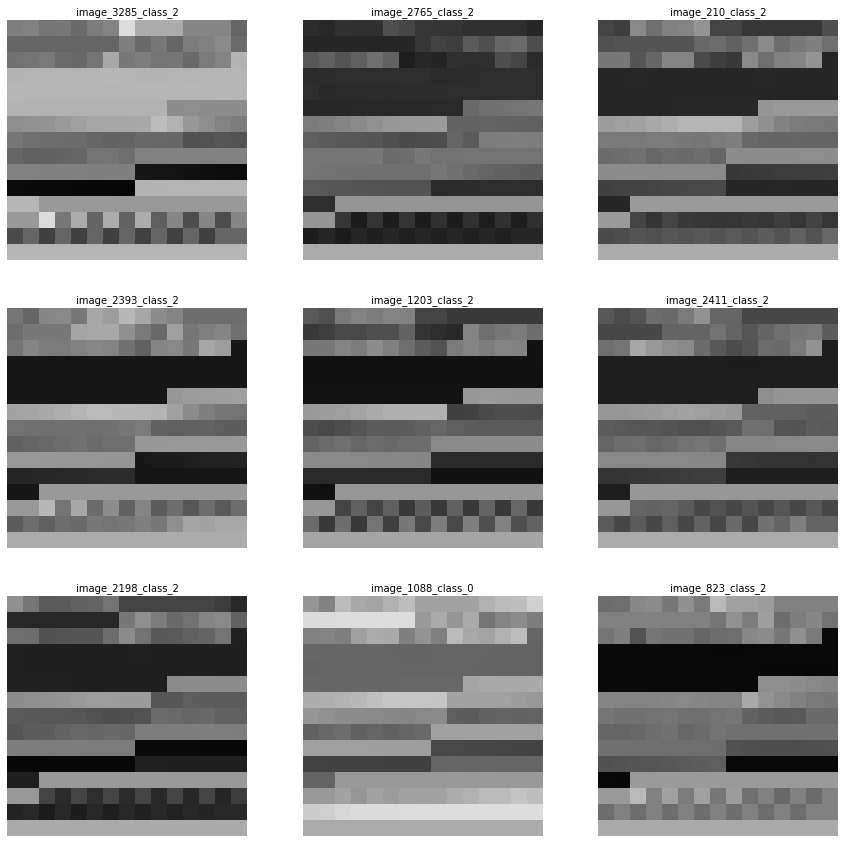

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns * rows + 1):
    index = np.random.randint(len(x_train)) # 随机抽取一幅图
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title('image_' + str(index) + '_class_' + str(int(y_train[index])),
             fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.savefig('C:/Users/82706/Desktop/远程实习汇报_李宏煜/第二次/samples.png',dpi=300)

# 4、网络的搭建与训练

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import f1_score

## 4.1 使用PyTorch搭建网络
### 网络结构如下所示(为了与原文的结果对比，这里也不加池化层)：
### 卷积层1---->Dropout层1---->卷积层2---->Dropout层2---->全连接层1---->Dropout层3---->全连接层2（输出层）

In [19]:
# 计算卷积层的输出维度
def calc_output_dim(n,f,p,s): # n输入维度，f:filter_size, p:padding, s:stride
    return (n-f+2*p)/s + 1

# "VALID" = without padding:
# "SAME" = with zero padding:

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,35, 
                     kernel_size=2,
                     stride=1,
                      padding=0),
            # 15 * 15 * 3 ---> 14 * 14 * 35  (14根据calc_output_dim(15,2,0,1)计算得到)
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,  
#                          stride=2), #  Default value is :attr:`kernel_size`
            # 14 * 14 * 35 ---> 7 * 7 *35 
            nn.Dropout(0.22),
            
            nn.Conv2d(35, 20,
                     kernel_size=2,
                     stride=2,
                      padding=0),
            # 7 * 7 * 35 --->
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            # 14 * 14 * 35 ---> 7 * 7 * 20  (7根据calc_output_dim(7,2,0,2)计算得到)
            nn.Dropout(0.05)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(7*7*20, 100),
            nn.ReLU(),
            nn.Dropout(0.22),
            nn.Linear(100, 3)
        )
    
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size()[0], -1)  # Flatten
        out = self.fc(out)
        return out

In [42]:
model.parameters

<bound method Module.parameters of ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 35, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.22)
    (3): Conv2d(35, 20, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.05)
  )
  (fc): Sequential(
    (0): Linear(in_features=980, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.22)
    (3): Linear(in_features=100, out_features=3, bias=True)
  )
)>

## 4.2 训练函数

In [38]:
# train the model 

def train(model, optimizer, epoch):
    for i in range(N_train):
        x_train0 = x_train[i*BAYCH_SIZE:(i+1)*BAYCH_SIZE,:]
        y_train0 = y_train[i*BAYCH_SIZE:(i+1)*BAYCH_SIZE]
        outputs = model(x_train0.float())
        y_train0 = y_train0.long()
        loss = criterion(outputs, y_train0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
            
# Test the model
def test(model,epoch):
    model.eval()
    test_loss = 0
    correct  = 0
    total = 0
    for i in range(N_test):
        x_test0 = x_test[i*BAYCH_SIZE:(i+1)*BAYCH_SIZE,:]
        y_test0 = y_test[i*BAYCH_SIZE:(i+1)*BAYCH_SIZE]
        y_test0 = y_test0.long()
        outputs = model(x_test0.float())
        _, predicted = torch.max(outputs.data, 1)
#         print('predicted',predicted)
        total += y_test0.size()[0]
        correct += (predicted == y_test0).sum().item()
    if epoch % 10 == 0:
        print('Test Accuracy of the model : {} %'.format(100 * correct / total))
        print('F-score of the model :%f'%(f1_score(y_test0,predicted,average='micro')))

### Pytorch跟Tf或者keras处理图片的方式有个不同之处，就是在Tf或者keras中，最后一个维度是通道数，而Pytorch中第一个维度是通道数，我这里用的是Pytorch，因此需要将维度做一下调整

In [21]:
x_train,  x_test = x_train.reshape(-1,3,15,15),x_test.reshape(-1,3,15,15)
x_train, y_train, x_test, y_test = torch.from_numpy(x_train),torch.from_numpy(y_train),torch.from_numpy(x_test),torch.from_numpy(y_test),

In [27]:
###  部分网络训练超参数
BAYCH_SIZE = 80 
EPOCHS = 200
Len_train = len(x_train)
N_train = int(Len_train / BAYCH_SIZE)
Len_test = len(x_test)
N_test = int(Len_test / BAYCH_SIZE)

### 训练过程中一定要加上类别权重，否则模型学不到东西

In [40]:
weights_ = [5.22135417, 5.43360434 ,0.38103383]  # 前面计算得到
model = ConvNet()
model = model.float()
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array(weights_)).float())
optimizer = optim.Adam(model.parameters())

### 训练函数

In [41]:
for epoch in tqdm(range(EPOCHS)):
    train(model, optimizer,epoch)
    test(model,epoch)

Train Epoch: 0 Loss: 1.043302
Test Accuracy of the model : 26.354166666666668 %
F-score of the model :0.237500
Train Epoch: 10 Loss: 0.407469
Test Accuracy of the model : 73.85416666666667 %
F-score of the model :0.762500
Train Epoch: 20 Loss: 0.311845
Test Accuracy of the model : 81.66666666666667 %
F-score of the model :0.800000
Train Epoch: 30 Loss: 0.250657
Test Accuracy of the model : 82.39583333333333 %
F-score of the model :0.825000
Train Epoch: 40 Loss: 0.244879
Test Accuracy of the model : 83.64583333333333 %
F-score of the model :0.837500
Train Epoch: 50 Loss: 0.171755
Test Accuracy of the model : 86.04166666666667 %
F-score of the model :0.912500
Train Epoch: 60 Loss: 0.114550
Test Accuracy of the model : 88.85416666666667 %
F-score of the model :0.887500
Train Epoch: 70 Loss: 0.081047
Test Accuracy of the model : 90.0 %
F-score of the model :0.875000
Train Epoch: 80 Loss: 0.074393
Test Accuracy of the model : 89.58333333333333 %
F-score of the model :0.875000
Train Epoch: 9